In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery

In [0]:
%load_ext google.colab.data_table

In [5]:
%env GCLOUD_PROJECT=willkommenvinzenz

env: GCLOUD_PROJECT=willkommenvinzenz


In [0]:
%%bigquery --project willkommenvinzenz
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.samples.gsod`

total_rows
0   114420316

In [0]:
# Save output in a variable `df`

%%bigquery --project yourprojectid df
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.samples.gsod`


ERROR:
 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/yourprojectid/jobs: Access Denied: Project yourprojectid: User does not have bigquery.jobs.create permission in project yourprojectid.

(job ID: 72665f4d-f9d7-4efc-8383-2917652ab4f5)

       -----Query Job SQL Follows-----       

    |    .    |    .    |    .    |    .    |
   1:SELECT 
   2:  COUNT(*) as total_rows
   3:FROM `bigquery-public-data.samples.gsod`
    |    .    |    .    |    .    |    .    |


In [0]:
project_id = 'willkommenvinzenz'

In [0]:
client = bigquery.Client(project=project_id)

row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.samples.gsod`''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 114420316 rows


In [0]:
df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.samples.gsod`
  WHERE RAND() < %d/%d
''' % (2000, row_count)).to_dataframe()

df.describe()

station_number   wban_number  ...  total_precipitation  snow_depth
count     1959.000000   1959.000000  ...          1804.000000  106.000000
mean    516233.125574  90202.398673  ...             0.072755   12.250943
std     299188.609518  26442.895199  ...             0.311872   12.530559
min      10230.000000     72.000000  ...             0.000000    0.400000
25%     266625.000000  99999.000000  ...             0.000000    3.500000
50%     561160.000000  99999.000000  ...             0.000000    8.300000
75%     725417.000000  99999.000000  ...             0.010000   18.100000
max     999999.000000  99999.000000  ...             5.910000   78.000000

[8 rows x 22 columns]

In [0]:
"""
Helper class to simplify common read-only BigQuery tasks.
"""


import pandas as pd
import time

class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.

    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1

        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.

        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))


In [0]:
bq_assistant = BigQueryHelper("bigquery-public-data", "github_repos")

In [0]:
bq_assistant.list_tables()

['commits',
 'contents',
 'files',
 'languages',
 'licenses',
 'sample_commits',
 'sample_contents',
 'sample_files',
 'sample_repos']

In [0]:
bq_assistant.head("licenses", num_rows=10)

repo_name       license
0       Manwar/WWW-Google-APIDiscovery  artistic-2.0
1              FindAllTogether/LifeIDE  artistic-2.0
2             skaji/perl6-HTTP-Tinyish  artistic-2.0
3                 jonathanstowe/Oyatul  artistic-2.0
4                gitpan/App-FastishCGI  artistic-2.0
5                     tiagodmed/nMaker  artistic-2.0
6   aur-archive/simutrans-pak64-german  artistic-2.0
7              ThomasGreiner/hypercube  artistic-2.0
8        Granada-pm/granada-pm-sources  artistic-2.0
9  venkatb4u/Memoization-in-Javascript  artistic-2.0

In [0]:
QUERY = """
        SELECT message
        FROM `bigquery-public-data.github_repos.commits`
        WHERE LENGTH(message) > 6 AND LENGTH(message) <= 20
        LIMIT 2000
        """
bq_assistant.estimate_query_size(QUERY)

20.03187828976661

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY,max_gb_scanned=1)

Query cancelled; estimated size of 20.03187828976661 exceeds limit of 1 GB


** query, size, pd df, visualize**

In [0]:
QUERY = """
        SELECT license, COUNT(*) AS count
        FROM `bigquery-public-data.github_repos.licenses`
        GROUP BY license
        ORDER BY COUNT(*) DESC
        """

In [0]:
bq_assistant.estimate_query_size(QUERY) # 0.024 GB = 24 MB

0.024197337217628956

In [0]:
df = bq_assistant.query_to_pandas_safe(QUERY)

In [0]:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))

Size of dataframe: 1223 Bytes


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

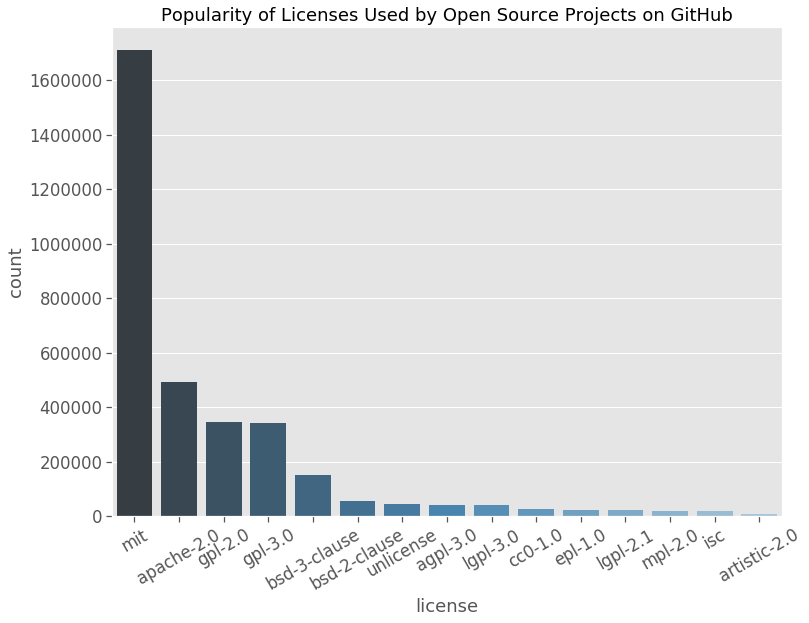

In [0]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

f, g = plt.subplots(figsize=(12, 9))
g = sns.barplot(x="license", y="count", data=df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.title("Popularity of Licenses Used by Open Source Projects on GitHub")
plt.show(g)

genome anaylsis

In [0]:
bq_assistant = BigQueryHelper("bigquery-public-data", "platinum_genomes_deepvariant_variants_20180823")

In [0]:
def qsize(query):
  return bq_assistant.estimate_query_size(query)

In [0]:
def qrun(query,limit=1):
  return bq_assistant.query_to_pandas_safe(query,max_gb_scanned=limit)

In [0]:
Q="""
WITH filtered_snp_calls AS (
   SELECT
     reference_name,
     c.name,
     CONCAT(reference_bases, '->', alternate_bases[ORDINAL(1)].alt) AS mutation
   FROM
     `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` AS v, UNNEST(v.call) AS c
   WHERE
     # Only include biallelic SNPs.
     reference_bases IN ('A','C','G','T')
     AND alternate_bases[ORDINAL(1)].alt IN ('A','C','G','T')
     AND (ARRAY_LENGTH(alternate_bases) = 1
       OR (ARRAY_LENGTH(alternate_bases) = 2 AND alternate_bases[ORDINAL(2)].alt = '<*>'))
     # Skip homozygous reference calls and no-calls.
     AND EXISTS (SELECT g FROM UNNEST(c.genotype) AS g WHERE g > 0)
     AND NOT EXISTS (SELECT g FROM UNNEST(c.genotype) AS g WHERE g < 0)
     # Include only high quality calls.
     AND NOT EXISTS (SELECT ft FROM UNNEST(c.filter) ft WHERE ft NOT IN ('PASS', '.'))
 ),

 mutation_type_counts AS (
   SELECT
     reference_name,
     name,
     SUM(CAST(mutation IN ('A->G', 'G->A', 'C->T', 'T->C') AS INT64)) AS transitions,
     SUM(CAST(mutation IN ('A->C', 'C->A', 'G->T', 'T->G',
                           'A->T', 'T->A', 'C->G', 'G->C') AS INT64)) AS transversions
   FROM filtered_snp_calls
   GROUP BY
     reference_name,
     name
 )

 SELECT
   reference_name,
   name,
   transitions,
   transversions,
   transitions/transversions AS titv
 FROM mutation_type_counts
 WHERE
   transversions > 0
 ORDER BY
   titv DESC,
   name
"""

In [0]:
qsize(Q)

5.950535892508924

In [0]:
illumina_df = qrun(Q,6)

In [0]:
illumina_df

reference_name     name  transitions  transversions      titv
0            chr22  NA12892        35299          15017  2.350603
1            chr22  NA12889        34091          14624  2.331168
2            chr17  NA12892        67297          28885  2.329825
3            chr22  NA12878        33627          14439  2.328901
4            chr22  NA12877        34751          14956  2.323549
..             ...      ...          ...            ...       ...
139           chrY  NA12892         3773           2478  1.522599
140           chrY  NA12890         3963           2618  1.513751
141           chrY  NA12891         2007           1426  1.407433
142           chrY  NA12877         1006            776  1.296392
143           chrY  NA12889         1034            813  1.271833

[144 rows x 5 columns]

In [0]:
 Q = """
 SELECT
   COUNT(1) AS number_of_rows
 FROM
   `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823`"""

In [0]:
rows_platinum_variants = qrun(Q)
rows_platinum_variants

number_of_rows
0       105923159

In [0]:
# iterate trough call columns, count alternate bases in vector without the non-variants
Q="""SELECT
  COUNT(1) AS number_of_non_variants
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call call
WHERE
  NOT EXISTS (SELECT 1
                FROM UNNEST(v.alternate_bases) AS alt
              WHERE
                alt.alt NOT IN ("<NON_REF>", "<*>"))"""
qsize(Q)
nonvariants = qrun(Q)
nonvariants

number_of_non_variants
0               143555264

count the total number of variant calls across all samples

In [0]:
Q="""
SELECT
  SUM(ARRAY_LENGTH(call)) AS number_of_calls
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823`"""
qsize(Q)
total_calls = qrun(Q)
total_calls

number_of_calls
0        182104652

In [0]:
# , is a join -> count rows after joining call column arrays with DF
Q="""SELECT
  COUNT(call) AS number_of_calls
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call"""
qsize(Q)
total_calls = qrun(Q)
total_calls

number_of_calls
0        182104652

Counting variant and non-variant segments

In [0]:
# , is a join -> count rows after joining call column arrays with DF
Q="""SELECT
  COUNT(1) AS number_of_non_variants
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call call
WHERE
  NOT EXISTS (SELECT 1
                FROM UNNEST(v.alternate_bases) AS alt
              WHERE
                alt.alt NOT IN ("<NON_REF>", "<*>"))
"""
print(qsize(Q))
num_variants = qrun(Q)
num_variants

0.5340448450297117


number_of_non_variants
0               143555264

Counting the variants called by each sample

In [0]:
# name is not unique to each row -> count call sets
Q="""SELECT
  call.name AS call_name,
  COUNT(call.name) AS call_count_for_call_set
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
GROUP BY
  call_name
ORDER BY
  call_name
"""
print(qsize(Q))
num_callsets = qrun(Q,2)
num_callsets

1.5263835601508617


call_name  call_count_for_call_set
0   NA12877                 31592135
1   NA12878                 28012646
2   NA12889                 31028550
3   NA12890                 30636087
4   NA12891                 33487348
5   NA12892                 27347886

In [0]:
# Filter out the non-variant segments to count just the variant rows:
Q="""SELECT
  call.name AS call_name,
  COUNT(call.name) AS call_count_for_call_set
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.alternate_bases) AS alt
          WHERE
            alt.alt NOT IN ("<NON_REF>", "<*>"))
GROUP BY
  call_name
ORDER BY
  call_name
"""
print(qsize(Q))
num_callsets_corrected = qrun(Q,3)
num_callsets_corrected

2.0604284051805735


call_name  call_count_for_call_set
0   NA12877                  6284275
1   NA12878                  6397315
2   NA12889                  6407532
3   NA12890                  6448600
4   NA12891                  6516669
5   NA12892                  6494997

Filtering true variants by genotype

In [0]:
# filter no-calls of (-1) and (0) for reference
Q="""SELECT
  call.name AS call_name,
  COUNT(call.name) AS call_count_for_call_set
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
WHERE
  EXISTS (SELECT 1 FROM UNNEST(call.genotype) AS gt WHERE gt > 0)
  AND NOT EXISTS (SELECT 1 FROM UNNEST(call.genotype) AS gt WHERE gt < 0)
GROUP BY
  call_name
ORDER BY
  call_name
"""
print(qsize(Q))
true_vars = qrun(Q,5)
true_vars

4.239954333752394


call_name  call_count_for_call_set
0   NA12877                  4486610
1   NA12878                  4502017
2   NA12889                  4422706
3   NA12890                  4528725
4   NA12891                  4424094
5   NA12892                  4495753

Count samples in the table

In [0]:
# number of samples is distinct num of call.name of join(table,call)
Q="""SELECT
  COUNT(DISTINCT call.name) AS number_of_callsets
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v,  v.call
"""
print(qsize(Q))
num_samples = qrun(Q,2)
num_samples

1.5263835601508617


number_of_callsets
0                   6

Num variants per chromosome

In [0]:
# select chromosomes with at least 1 variant, order by chr[xy] (regex)
Q="""SELECT
  reference_name,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  reference_name
ORDER BY
  CASE
    WHEN SAFE_CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) < 10
      THEN CONCAT('0', REGEXP_REPLACE(reference_name, '^chr', ''))
      ELSE REGEXP_REPLACE(reference_name, '^chr', '')
  END
"""
print(qsize(Q))
num_var_chrom = qrun(Q,4)
num_var_chrom

3.341447635553777


reference_name  number_of_variant_rows
0            chr1                  615000
1            chr2                  646401
2            chr3                  542315
3            chr4                  578600
4            chr5                  496202
5            chr6                  512152
6            chr7                  459506
7            chr8                  416376
8            chr9                  344985
9           chr10                  396773
10          chr11                  391260
11          chr12                  382841
12          chr13                  298044
13          chr14                  258756
14          chr15                  234569
15          chr16                  247671
16          chr17                  224403
17          chr18                  227200
18          chr19                  192538
19          chr20                  168958
20          chr21                  121882
21          chr22                  112338
22           chrX                  231125
23           chrY                   15357

Counting high-quality variants per sample

In [15]:
# Filter column holds quality as "pass" if qual is good, else "RefCall"
Q="""SELECT
  call_filter,
  COUNT(call_filter) AS number_of_calls
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v,
  v.call,
  UNNEST(call.FILTER) AS call_filter
GROUP BY
  call_filter
ORDER BY
  number_of_calls
"""
print(qsize(Q))
sample_qual = qrun(Q)
sample_qual

0.24804932065308094


call_filter  number_of_calls
0     RefCall         11681534
1        PASS         26867854

filtering for high quality variant calls

In [17]:
# If the FILTER column contains the value PASS, it is expected that the column will contain no other values
Q="""SELECT
  reference_name,
  start_position,
  end_position,
  reference_bases,
  call.name AS call_name,
  (SELECT STRING_AGG(call_filter) FROM UNNEST(call.FILTER) AS call_filter) AS filters,
  ARRAY_LENGTH(call.FILTER) AS filter_count
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
WHERE
  EXISTS (SELECT 1 FROM UNNEST(call.FILTER) AS call_filter WHERE call_filter = 'PASS')
  AND ARRAY_LENGTH(call.FILTER) > 1
ORDER BY
  filter_count DESC, reference_name, start_position, end_position, reference_bases, call_name
LIMIT
  10

"""
print(qsize(Q))
num_lhQual = qrun(Q,5)
num_lhQual
# expect no results!

4.281298340298235


Empty DataFrame
Columns: [reference_name, start_position, end_position, reference_bases, call_name, filters, filter_count]
Index: []

Counting all high quality calls for each sample - count ALL calls without the non-PASS calls

In [18]:
# If the FILTER column contains the value PASS, it is expected that the column will contain no other values
Q="""SELECT
  call.name AS call_name,
  COUNT(1) AS number_of_calls
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
WHERE
  NOT EXISTS (SELECT 1 FROM UNNEST(call.FILTER) AS call_filter WHERE call_filter != 'PASS')
GROUP BY
  call_name
ORDER BY
  call_name
"""
print(qsize(Q))
num_highQual = qrun(Q,5)
num_highQual

1.7744328808039427


call_name  number_of_calls
0   NA12877         29795946
1   NA12878         26118774
2   NA12889         29044992
3   NA12890         28717437
4   NA12891         31395995
5   NA12892         25349974

Counting all high quality true variant calls for each sample

In [23]:
# all calls with at least one true variant per sample
Q="""SELECT
  call.name AS call_name,
  COUNT(1) AS number_of_calls
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
WHERE
  NOT EXISTS (SELECT 1 FROM UNNEST(call.FILTER) AS call_filter WHERE call_filter != 'PASS')
  AND EXISTS (SELECT 1 FROM UNNEST(call.genotype) as gt WHERE gt > 0)
GROUP BY
  call_name
ORDER BY
  call_name
"""
print(qsize(Q))
num_highQual_true_var_calls = qrun(Q,5)
num_highQual_true_var_calls

4.488003654405475


call_name  number_of_calls
0   NA12877          4486610
1   NA12878          4502017
2   NA12889          4422706
3   NA12890          4528725
4   NA12891          4424094
5   NA12892          4495753

BEST PRACTICES
step by step constructing of a complex query

In [0]:
# UNNEST returns vector as rows, 

Q="""SELECT
  reference_name,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call
          WHERE EXISTS (SELECT 1
                          FROM UNNEST(call.genotype) AS gt
                        WHERE gt > 0))
GROUP BY
  reference_name
ORDER BY
  reference_name
"""
print(qsize(Q))
vars_per_chr = qrun(Q)
vars_per_chr

In [0]:
# replace the 2nd nested EXIST with a join (,):

Q="""SELECT
  reference_name,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  reference_name
ORDER BY
  reference_name"""
print(qsize(Q))
vars_per_chr = qrun(Q)
vars_per_chr

In [0]:
# neat, but it can not be sorted because of the "chr" suffix.
# this can be solved by replacing the "chr" with reference via regex [REGEXP_REPLACE(reference_name, '^chr', '')].

Q="""SELECT
  REGEXP_REPLACE(reference_name, '^chr', '') AS chromosome,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  chromosome
ORDER BY
  chromosome"""
print(qsize(Q))
vars_per_chr = qrun(Q)
vars_per_chr

In [0]:
# cast the output chromosome no to int (it is string) to have proper ascending order.
Q="""SELECT
  CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) AS chromosome,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  chromosome
ORDER BY
  chromosome"""

# but this query will fail due to chrM and chrX/Y are not numeric. In this case, a SAFE_CAST can avoid this casting error.
# concatenate a 0 in front 
Q="""SELECT
  CASE
    WHEN SAFE_CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) < 10
      THEN CONCAT('0', REGEXP_REPLACE(reference_name, '^chr', ''))
      ELSE REGEXP_REPLACE(reference_name, '^chr', '')
  END AS chromosome,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  chromosome
ORDER BY
  chromosome"""

# final adjustment: show reference_name column instead of chromosome alias

Q="""SELECT
  reference_name,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  reference_name
ORDER BY
  CASE
    WHEN SAFE_CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) < 10
      THEN CONCAT('0', REGEXP_REPLACE(reference_name, '^chr', ''))
      ELSE REGEXP_REPLACE(reference_name, '^chr', '')
  END
"""

print(qsize(Q))
vars_per_chr = qrun(Q,4)
vars_per_chr

3.341447635553777


reference_name  number_of_variant_rows
0            chr1                  615000
1            chr2                  646401
2            chr3                  542315
3            chr4                  578600
4            chr5                  496202
5            chr6                  512152
6            chr7                  459506
7            chr8                  416376
8            chr9                  344985
9           chr10                  396773
10          chr11                  391260
11          chr12                  382841
12          chr13                  298044
13          chr14                  258756
14          chr15                  234569
15          chr16                  247671
16          chr17                  224403
17          chr18                  227200
18          chr19                  192538
19          chr20                  168958
20          chr21                  121882
21          chr22                  112338
22           chrX                  231125
23           chrY                   15357

User-defined FUNCTIONS!

In [0]:
# the function is passed a parameter
Q="""
CREATE TEMPORARY FUNCTION SortableChromosome(reference_name STRING)
  RETURNS STRING AS (
  -- Remove the leading chr (if any) in the reference_name
  -- If the chromosome is 1 - 9, prepend a "0" since
  -- "2" sorts after "10", but 02 sorts before 10.
  CASE
    WHEN SAFE_CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) < 10
      THEN CONCAT('0', REGEXP_REPLACE(reference_name, '^chr', ''))
      ELSE REGEXP_REPLACE(reference_name, '^chr', '')
  END
);

SELECT
  reference_name,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  reference_name
ORDER BY SortableChromosome(reference_name)
"""

# example with javascript
Q="""
CREATE TEMPORARY FUNCTION SortableChromosome(reference_name STRING)
  RETURNS STRING LANGUAGE js AS "\
  // Remove the leading chr (if any) in the reference_name\
  var chr = reference_name.replace(/^chr/, '');\
\
  // If the chromosome is 1 - 9, prepend a 0 since\
  // 2 sorts after 10, but 02 sorts before 10.\
  if (chr.length == 1 && '123456789'.indexOf(chr) >= 0) {\
    return '0' + chr;\
  }\
\
  return chr;"
;

SELECT
  reference_name,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  reference_name
ORDER BY SortableChromosome(reference_name)
"""
print(qsize(Q))
vars_per_chr = qrun(Q,4)
vars_per_chr

3.341447635553777


reference_name  number_of_variant_rows
0           chr16                  247671
1            chr5                  496202
2           chr12                  382841
3            chrX                  231125
4           chr20                  168958
5           chr11                  391260
6           chr18                  227200
7           chr21                  121882
8            chr1                  615000
9            chr2                  646401
10          chr15                  234569
11          chr13                  298044
12          chr14                  258756
13          chr17                  224403
14          chr22                  112338
15           chr8                  416376
16           chr3                  542315
17           chr6                  512152
18          chr10                  396773
19          chr19                  192538
20           chrY                   15357
21           chr9                  344985
22           chr4                  578600
23           chr7                  459506